In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.set_index(pd.to_datetime(traffic['date_time']), drop=True, inplace=True)

In [ ]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
def ts_eval_metrics(y_true, y_pred):
    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metrics results: ')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mape(y_true, y_pred)}')
    print(f'R^2: {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)

In [ ]:
X_train, X_valid = train_test_split(traffic.traffic_volume, test_size=0.01, shuffle=False)

In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))

In [ ]:
# get X, y in such a way to predict horizon values of y on past window values of X
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
    X, y = [], []
    start += window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i, i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [ ]:
hist_window = 168  # observe past 48 hours while training, try week = 168 hours?
horizon = 1  # to predict 49 hour - one-step model
train_split = 32000 # originaly 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_train_scaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_train_scaled, train_split, None, hist_window, horizon)

In [ ]:
batch_size = 256
buffer_size = 200 # originaly 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/lstm_single_step_168.h5'

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(100, input_shape=X_train_uni.shape[-2:],
                                                         return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.LSTM(50, return_sequences=False),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(1),
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 150
# learning rate, lr_scheduler?
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, shuffle=False, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
                                                                verbose=1, mode='min'), 
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 12s 91ms/step - loss: 0.0651 - val_loss: 0.0316
Epoch 2/150
100/100 [==============================] - 8s 82ms/step - loss: 0.0335 - val_loss: 0.0240
Epoch 3/150
100/100 [==============================] - 8s 82ms/step - loss: 0.0230 - val_loss: 0.0158
Epoch 4/150
100/100 [==============================] - 8s 81ms/step - loss: 0.0183 - val_loss: 0.0120
Epoch 5/150
100/100 [==============================] - 8s 82ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 6/150
100/100 [==============================] - 8s 82ms/step - loss: 0.0160 - val_loss: 0.0113
Epoch 7/150
100/100 [==============================] - 8s 83ms/step - loss: 0.0154 - val_loss: 0.0118
Epoch 8/150
100/100 [==============================] - 8s 82ms/step - loss: 0.0132 - val_loss: 0.0108
Epoch 9/150
100/100 [==============================] - 8s 83ms/step - loss: 0.0140 - val_loss: 0.0106
Epoch 10/150
100/100 [==============================] - 8s 82ms/step - loss: 0.01

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

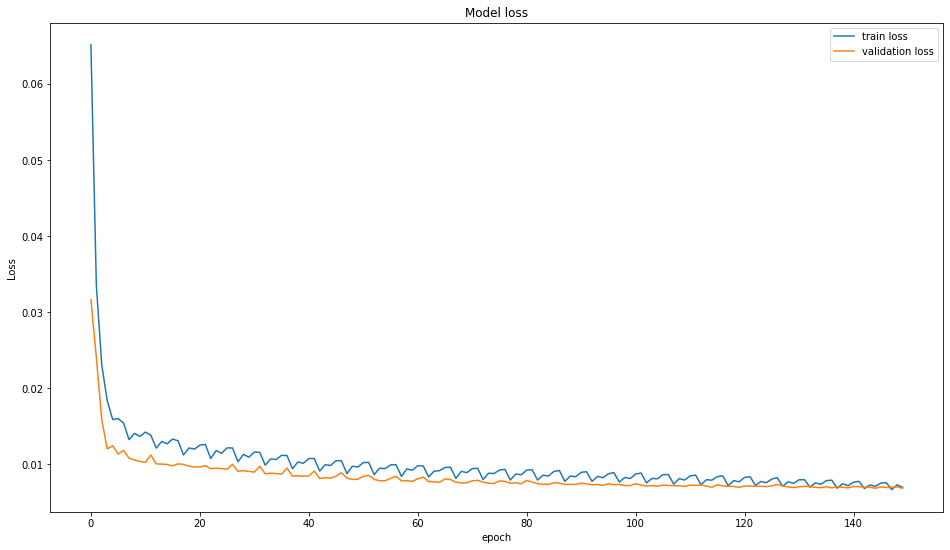

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
X_train_uni.shape, X_valid_uni.shape, traffic.shape, X_valid.shape, X_train.shape, X_train_scaled.shape

((29952, 48, 1), (4729, 48, 1), (35130, 9), (352,), (34778,), (34778, 1))

In [ ]:
model.input_shape

(None, 168, 1)

In [ ]:
validatehori = X_train.tail(168).values  # take last (originally = 48) hours from train and predict next hour
result = []
window_len = 1000 # originaly 10, 100

val_rescaled = scaler.transform(validatehori.reshape(-1, 1))  # fit_transform why?
for _ in range(1, window_len + 1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    preds = trained_model.predict(val_rescaled)
    result.append(preds[0])
    val_rescaled = np.append(val_rescaled[:, 1:], [[preds]])

In [ ]:
result_inverse = scaler.inverse_transform(result)

In [ ]:
result_inverse[:10], X_valid[:10] # first 10 predicted hours after X_train.shape[0] from 100 totaly predicted

(array([[ 452.7312398 ],
        [ 580.07384062],
        [1864.66834545],
        [4854.14447784],
        [6207.38259315],
        [5706.66762829],
        [5050.19556046],
        [4713.62020016],
        [4904.22339439],
        [5014.51069832]]), date_time
 2018-09-13 01:00:00     413
 2018-09-13 02:00:00     332
 2018-09-13 03:00:00     383
 2018-09-13 04:00:00     914
 2018-09-13 05:00:00    3052
 2018-09-13 06:00:00    5830
 2018-09-13 07:00:00    6433
 2018-09-13 08:00:00    6162
 2018-09-13 09:00:00    5092
 2018-09-13 10:00:00    4584
 Name: traffic_volume, dtype: int64)

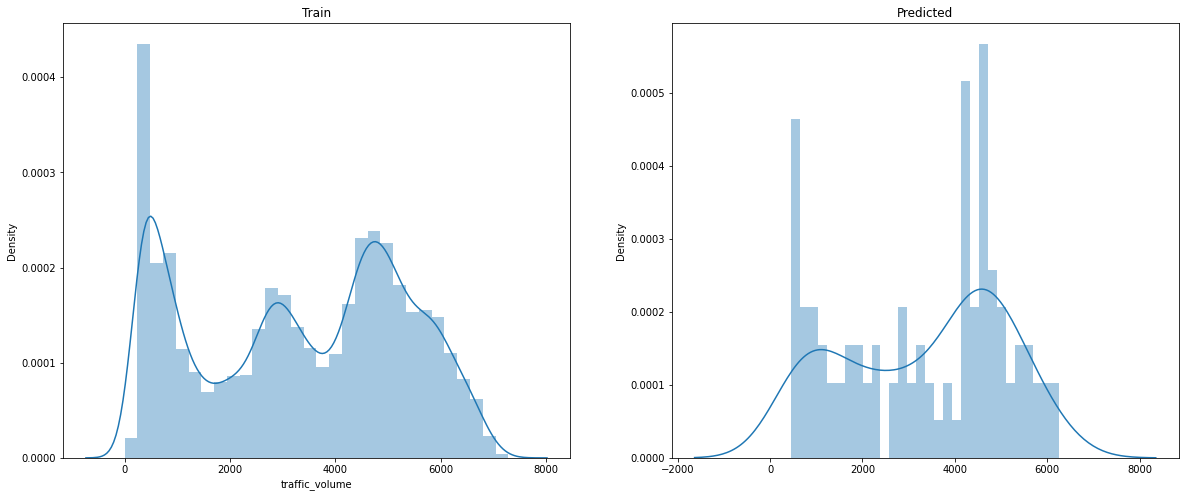

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.title('Train')
sns.distplot(X_train, bins=30)
plt.subplot(122)
plt.title('Predicted')
sns.distplot(result_inverse, bins=30)
plt.show()

In [ ]:
ts_eval_metrics(X_valid[2:100], result_inverse[:-2]) # 2 hours shifted? why?

Evaluation metrics results: 
MSE: 330625.30434512795
MAE: 428.8416053105374
RMSE: 575.0002646478764
MAPE: 185.15744406230138
R^2: 0.9074201613646691



In [ ]:
ts_eval_metrics(X_valid[2:352], result_inverse[:350])  # get worse

Evaluation metrics results: 
MSE: 4243452.467004133
MAE: 1599.947397083555
RMSE: 2059.9641907091814
MAPE: 139.53399730958182
R^2: -0.17335007012757342



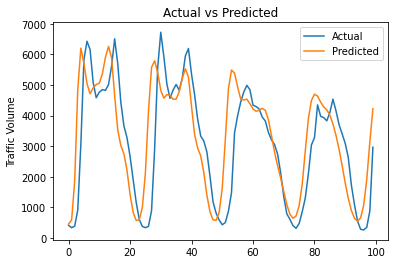

In [ ]:
plt.plot(X_valid[:100].tolist())
plt.plot(result_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

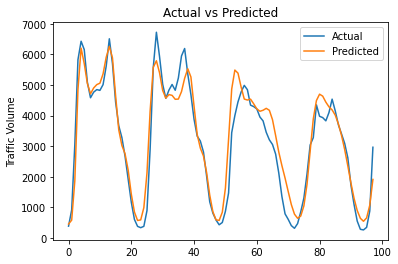

In [ ]:
plt.plot(X_valid[2:100].tolist())
plt.plot(result_inverse[:-2])
plt.title('Actual vs Predicted, shifted by 2 hours')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
X_train.tail(6)

date_time
2018-09-12 19:00:00    3510
2018-09-12 20:00:00    3064
2018-09-12 21:00:00    2705
2018-09-12 22:00:00    1813
2018-09-12 23:00:00    2842
2018-09-13 00:00:00     699
Name: traffic_volume, dtype: int64

In [ ]:
X_valid.head(3)

date_time
2018-09-13 01:00:00    413
2018-09-13 02:00:00    332
2018-09-13 03:00:00    383
Name: traffic_volume, dtype: int64

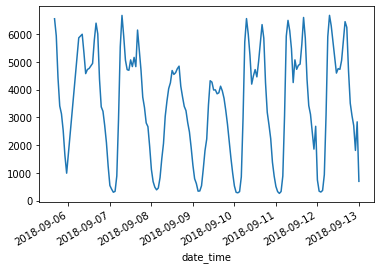

In [ ]:
X_train.iloc[-168:].plot()
plt.show()
# strong daily seasonality

In [ ]:
# univariate horizon

In [ ]:
validate = traffic['traffic_volume'].tail(250)
traffic.drop(traffic['traffic_volume'].tail(250).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic['date_time']

In [ ]:
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)

In [ ]:
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/lstm_uni_1.h5'

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(100, input_shape=X_train_uni.shape[-2:],
                                                         return_sequences=True),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.LSTM(50, return_sequences=False),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(units=horizon),
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 12s 43ms/step - loss: 0.0890 - val_loss: 0.0505
Epoch 2/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0575 - val_loss: 0.0483
Epoch 3/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0535 - val_loss: 0.0597
Epoch 4/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0484 - val_loss: 0.0434
Epoch 5/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0497 - val_loss: 0.0394
Epoch 6/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0461 - val_loss: 0.0395
Epoch 7/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0454 - val_loss: 0.0360
Epoch 8/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0453 - val_loss: 0.0362
Epoch 9/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0441 - val_loss: 0.0427
Epoch 10/150
100/100 [==============================] - 3s 28ms/step - loss: 0.04

In [ ]:
trained_model = tf.keras.models.load_model(model_path)
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 71,510
Trainable params: 71,510
Non-trainable params: 0
_________________________________________________________________


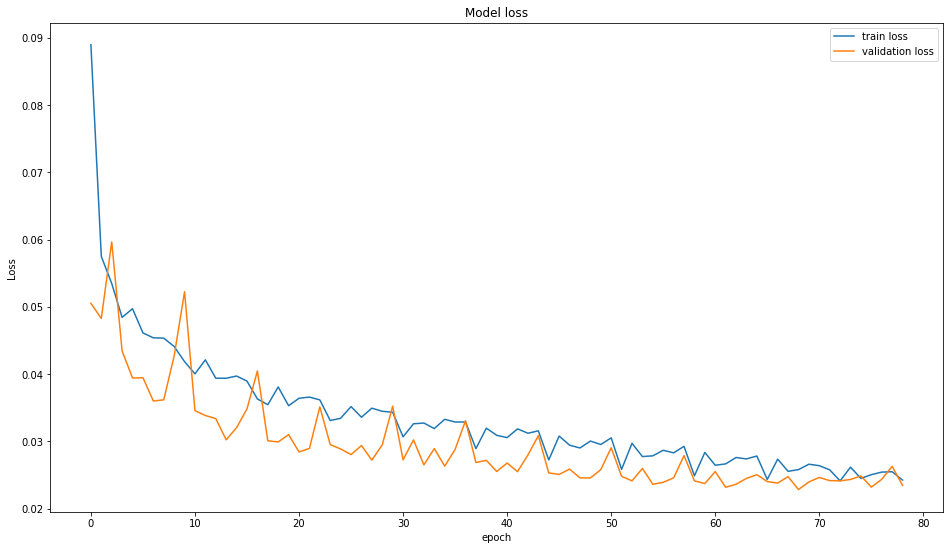

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
validatehist = traffic['traffic_volume'].tail(48).values
result = []
window_len = 250
val_rescaled = scaler.transform(validatehist.reshape(-1,1))
for _ in range(1, window_len + 1, 10):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    preds = trained_model.predict(val_rescaled)
    result += preds[0].tolist()
    val_rescaled = np.append(val_rescaled[:, :], [[preds]])[-48:]
    print(val_rescaled)

In [ ]:
preds_inverse = scaler.inverse_transform(np.array(result).reshape(-1,1))

In [ ]:
ts_eval_metrics(validate, preds_inverse)

Evaluation metrics results: 
MSE: 6847554.947300257
MAE: 2284.308541748047
RMSE: 2616.7833206630344
MAPE: 153.82835640305916
R^2: -0.9082285381279036



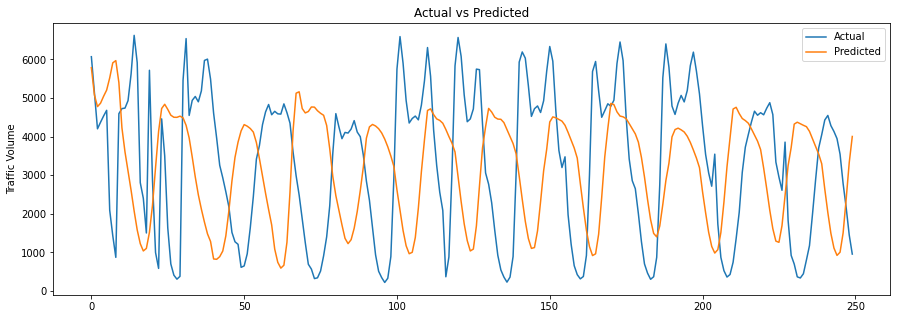

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(validate.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
ts_eval_metrics(validate[:10], preds_inverse[:10])

Evaluation metrics results: 
MSE: 5966288.611123613
MAE: 1626.924953365326
RMSE: 2442.5987413252333
MAPE: 106.41510288543223
R^2: -1.251251059660691



In [ ]:
# Bidirectional LSTM single-step

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)

In [ ]:
validate = traffic.traffic_volume.tail(100)
traffic.drop(traffic.traffic_volume.tail(100).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time

In [ ]:
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
hist_window = 48
horizon = 1
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)

In [ ]:
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/lstm_bidir_step.h5'

In [ ]:
seq = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                                     input_shape=X_train_uni.shape[-2:]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
       tf.keras.layers.Dense(20, activation='softmax'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(units=1),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 184,041
Trainable params: 184,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 14s 81ms/step - loss: 0.1024 - val_loss: 0.0742
Epoch 2/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0727 - val_loss: 0.0417
Epoch 3/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0424 - val_loss: 0.0271
Epoch 4/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0287 - val_loss: 0.0171
Epoch 5/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0253 - val_loss: 0.0183
Epoch 6/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0211 - val_loss: 0.0134
Epoch 7/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0202 - val_loss: 0.0121
Epoch 8/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0192 - val_loss: 0.0115
Epoch 9/150
100/100 [==============================] - 6s 60ms/step - loss: 0.0183 - val_loss: 0.0113
Epoch 10/150
100/100 [==============================] - 6s 60ms/step - loss: 0.01

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

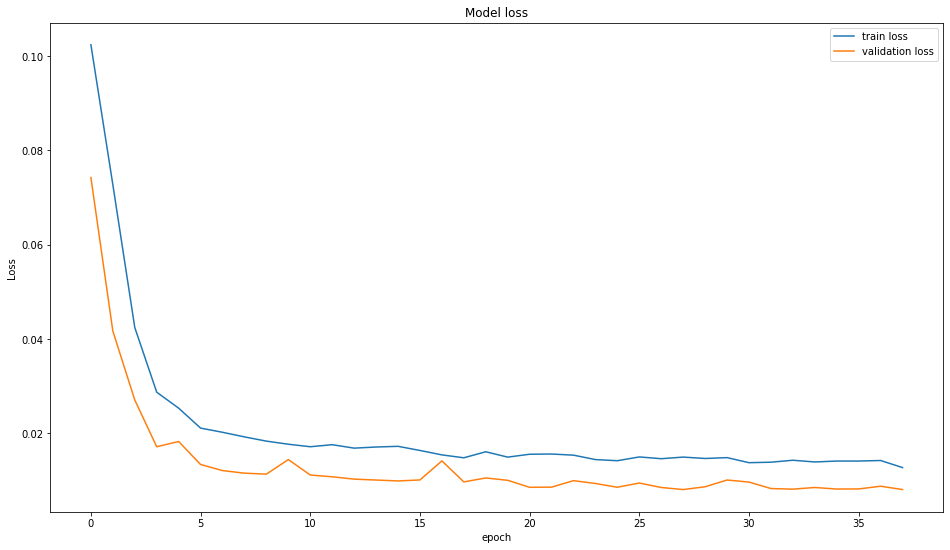

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
window_len = 100
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
for _ in range(1, window_len + 1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    preds = trained_model.predict(val_rescaled)
    result.append(preds[0])
    val_rescaled = np.append(val_rescaled[:, 1:], [[preds]])

In [ ]:
preds_inverse = scaler.inverse_transform(result)

In [ ]:
ts_eval_metrics(validate[:10], preds_inverse[:10])

Evaluation metrics results: 
MSE: 226281.46316667786
MAE: 446.4195149421692
RMSE: 475.6905119578042
MAPE: 149.10332475874333
R^2: 0.9426563349583199



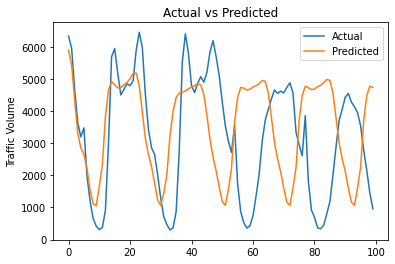

In [ ]:
plt.plot(validate.tolist()[:100])
plt.plot(preds_inverse[:100])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()
# the model is not able to predict more than future 10 hours, it increases error from previous predictions

In [ ]:
# Bidirectional LSTM Univariate horizon style

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)

In [ ]:
validate = traffic.traffic_volume.tail(100)
traffic.drop(traffic.traffic_volume.tail(100).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time

In [ ]:
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)

In [ ]:
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/lstm_bidir_horizon.h5'

In [ ]:
seq = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                                     input_shape=X_train_uni.shape[-2:]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
       tf.keras.layers.Dense(20, activation='softmax'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(units=horizon),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 184,230
Trainable params: 184,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 100
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 14s 76ms/step - loss: 0.1788 - val_loss: 0.1294
Epoch 2/100
100/100 [==============================] - 6s 60ms/step - loss: 0.1047 - val_loss: 0.0876
Epoch 3/100
100/100 [==============================] - 6s 59ms/step - loss: 0.0845 - val_loss: 0.0755
Epoch 4/100
100/100 [==============================] - 6s 63ms/step - loss: 0.0773 - val_loss: 0.0702
Epoch 5/100
100/100 [==============================] - 6s 60ms/step - loss: 0.0735 - val_loss: 0.0665
Epoch 6/100
100/100 [==============================] - 6s 60ms/step - loss: 0.0691 - val_loss: 0.0643
Epoch 7/100
100/100 [==============================] - 6s 60ms/step - loss: 0.0676 - val_loss: 0.0615
Epoch 8/100
100/100 [==============================] - 6s 60ms/step - loss: 0.0682 - val_loss: 0.0607
Epoch 9/100
100/100 [==============================] - 6s 60ms/step - loss: 0.0659 - val_loss: 0.0647
Epoch 10/100
100/100 [==============================] - 6s 59ms/step - loss: 0.06

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

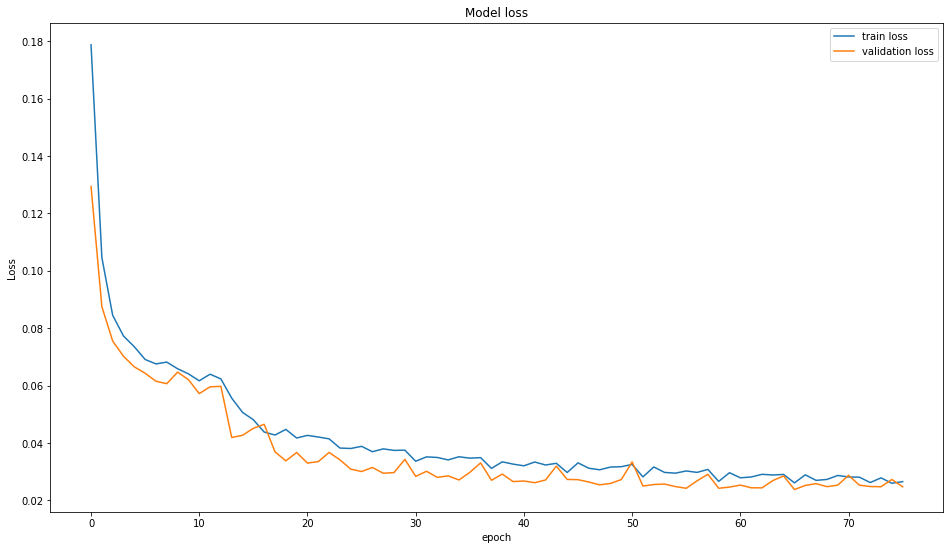

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
window_len = 100
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
preds = trained_model.predict(val_rescaled)
preds_inverse = scaler.inverse_transform(preds)

In [ ]:
ts_eval_metrics(validate[:10], preds_inverse[0])

Evaluation metrics results: 
MSE: 447929.7639078468
MAE: 576.370166015625
RMSE: 669.2755515539521
MAPE: 37.78290151414717
R^2: 0.8864867939942112



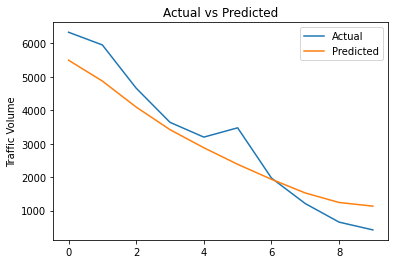

In [ ]:
plt.plot(validate.tolist()[:10])
plt.plot(preds_inverse[0])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()
# the model is not able to predict more than future 10 hours, it increases error from previous predictions

In [ ]:
# GRU univariate single-step

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.traffic_volume.tail(10)
traffic.drop(traffic.traffic_volume.tail(10).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))
hist_window = 48
horizon = 1
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/gru_step.h5'

In [ ]:
seq = [
       tf.keras.layers.GRU(100, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.GRU(50, return_sequences=False),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(units=1),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 48, 100)           30900     
_________________________________________________________________
dropout_9 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 8s 40ms/step - loss: 0.0478 - val_loss: 0.0203
Epoch 2/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0217 - val_loss: 0.0137
Epoch 3/150
100/100 [==============================] - 3s 30ms/step - loss: 0.0179 - val_loss: 0.0131
Epoch 4/150
100/100 [==============================] - 3s 29ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 5/150
100/100 [==============================] - 3s 29ms/step - loss: 0.0155 - val_loss: 0.0112
Epoch 6/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0145 - val_loss: 0.0104
Epoch 7/150
100/100 [==============================] - 3s 28ms/step - loss: 0.0143 - val_loss: 0.0101
Epoch 8/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0145 - val_loss: 0.0105
Epoch 9/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0141 - val_loss: 0.0105
Epoch 10/150
100/100 [==============================] - 3s 27ms/step - loss: 0.013

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

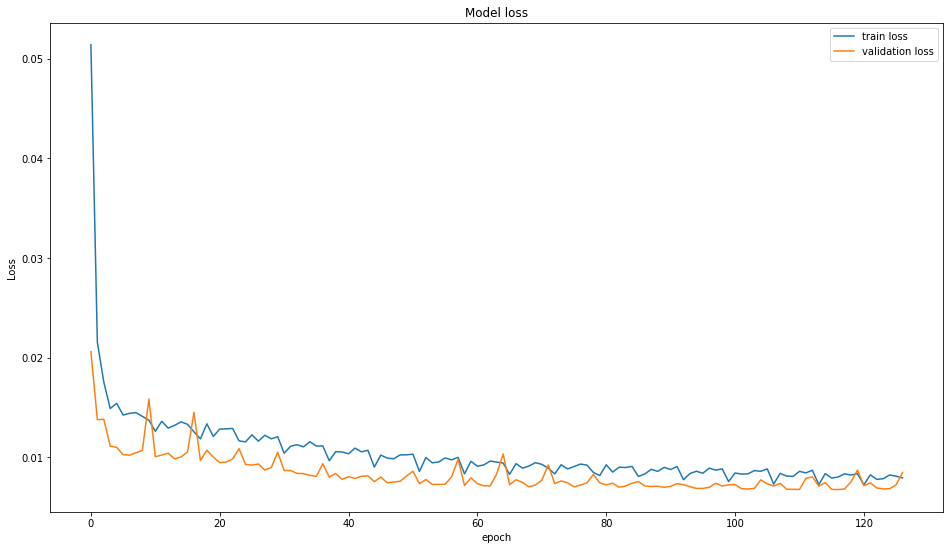

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
window_len = 10
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
for _ in range(1, window_len + 1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    preds = trained_model.predict(val_rescaled)
    result.append(preds[0])
    val_rescaled = np.append(val_rescaled[:, 1:], [[preds]])

In [ ]:
preds_inverse = scaler.inverse_transform(result)

In [ ]:
ts_eval_metrics(validate, preds_inverse)

Evaluation metrics results: 
MSE: 1087989.1529901414
MAE: 847.4084642410278
RMSE: 1043.0671852714672
MAPE: 72.20760161101302
R^2: 0.29366106553774574



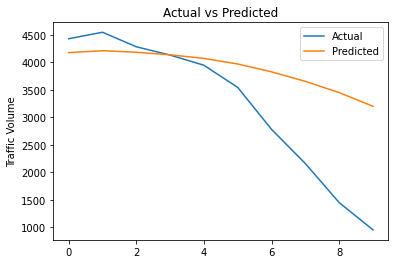

In [ ]:
plt.plot(validate.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# GRU horizon

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.traffic_volume.tail(10)
traffic.drop(traffic.traffic_volume.tail(10).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/gru_horizon.h5'

In [ ]:
seq = [
       tf.keras.layers.GRU(100, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.GRU(50, return_sequences=False),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(units=horizon),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 48, 100)           30900     
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 54,210
Trainable params: 54,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 7s 41ms/step - loss: 0.0901 - val_loss: 0.0497
Epoch 2/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0582 - val_loss: 0.0506
Epoch 3/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0503 - val_loss: 0.0583
Epoch 4/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0454 - val_loss: 0.0363
Epoch 5/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0460 - val_loss: 0.0363
Epoch 6/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0428 - val_loss: 0.0329
Epoch 7/150
100/100 [==============================] - 3s 31ms/step - loss: 0.0422 - val_loss: 0.0317
Epoch 8/150
100/100 [==============================] - 3s 30ms/step - loss: 0.0425 - val_loss: 0.0341
Epoch 9/150
100/100 [==============================] - 3s 30ms/step - loss: 0.0415 - val_loss: 0.0366
Epoch 10/150
100/100 [==============================] - 3s 30ms/step - loss: 0.039

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

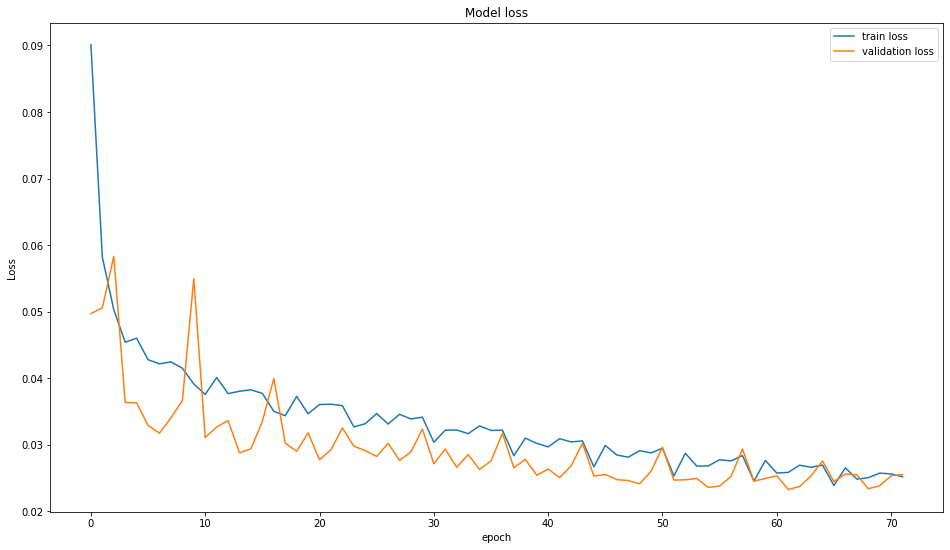

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
val_rescaled = scaler.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
preds = trained_model.predict(val_rescaled)

In [ ]:
preds_inverse = scaler.inverse_transform(result)

In [ ]:
ts_eval_metrics(validate, preds_inverse)

Evaluation metrics results: 
MSE: 978181.5061047757
MAE: 803.0831597805023
RMSE: 989.0305890642492
MAPE: 62.05242392917171
R^2: 0.364949842713192



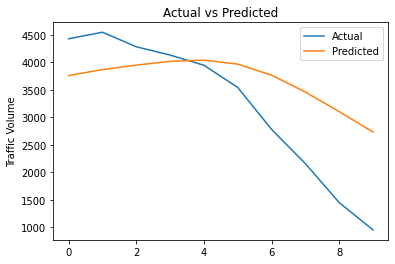

In [ ]:
plt.plot(validate.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# AutoEncoder single-step

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.traffic_volume.tail(10)
traffic.drop(traffic.traffic_volume.tail(10).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))
hist_window = 48
horizon = 1
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/aelstm_horizon.h5'

In [ ]:
seq = [
       tf.keras.layers.LSTM(100, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.LSTM(50, return_sequences=True),
       tf.keras.layers.LSTM(15),
       tf.keras.layers.RepeatVector(y_train_uni.shape[1]),
       tf.keras.layers.LSTM(100, return_sequences=True),
       tf.keras.layers.LSTM(50, return_sequences=True),
       tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 48, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 15)                3960      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 15)            0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 1, 100)            46400     
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             30200     
                                                        

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 22s 91ms/step - loss: 0.0966 - val_loss: 0.0752
Epoch 2/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0750 - val_loss: 0.0755
Epoch 3/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0754 - val_loss: 0.0786
Epoch 4/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0616 - val_loss: 0.0316
Epoch 5/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0210 - val_loss: 0.0186
Epoch 6/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0123 - val_loss: 0.0098
Epoch 7/150
100/100 [==============================] - 7s 68ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 8/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0121 - val_loss: 0.0095
Epoch 9/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 10/150
100/100 [==============================] - 7s 69ms/step - loss: 0.01

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

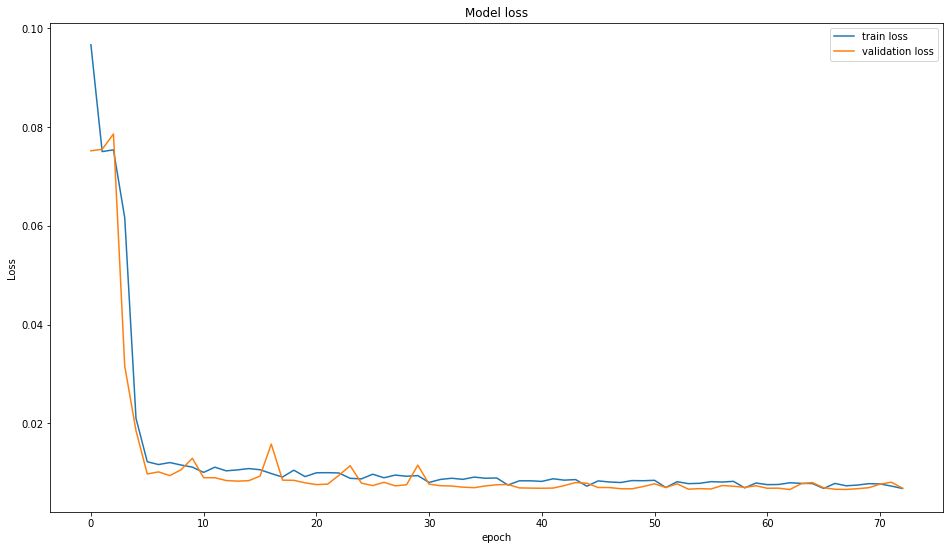

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
window_len = 10
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
for _ in range(1, window_len + 1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    preds = trained_model.predict(val_rescaled)
    result.append(preds[0])
    val_rescaled = np.append(val_rescaled[:, 1:], [[preds]])

In [ ]:
preds_inverse = scaler.inverse_transform(np.array(result).reshape(-1,1))

In [ ]:
ts_eval_metrics(validate, preds_inverse)

Evaluation metrics results: 
MSE: 180886.57198648603
MAE: 365.0640014648437
RMSE: 425.3076204190163
MAPE: 60.260497640720146
R^2: 0.8825657147736085



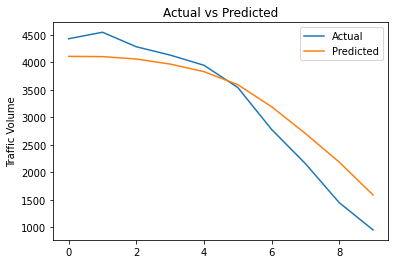

In [ ]:
plt.plot(validate.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# AutoEncoder LSTM horizon style

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.traffic_volume.tail(10)
traffic.drop(traffic.traffic_volume.tail(10).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/aelstm_horizon2.h5'

In [ ]:
seq = [
       tf.keras.layers.LSTM(100, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.LSTM(50, return_sequences=True),
       tf.keras.layers.LSTM(15),
       tf.keras.layers.RepeatVector(y_train_uni.shape[1]),
       tf.keras.layers.LSTM(100, return_sequences=True),
       tf.keras.layers.LSTM(50, return_sequences=True),
       tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 48, 100)           40800     
                                                                 
 lstm_6 (LSTM)               (None, 48, 50)            30200     
                                                                 
 lstm_7 (LSTM)               (None, 15)                3960      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 15)           0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 10, 100)           46400     
                                                                 
 lstm_9 (LSTM)               (None, 10, 50)            30200     
                                                      

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 18s 99ms/step - loss: 0.0933 - val_loss: 0.0621
Epoch 2/150
100/100 [==============================] - 8s 78ms/step - loss: 0.0576 - val_loss: 0.0566
Epoch 3/150
100/100 [==============================] - 8s 77ms/step - loss: 0.0539 - val_loss: 0.0729
Epoch 4/150
100/100 [==============================] - 8s 81ms/step - loss: 0.0476 - val_loss: 0.0450
Epoch 5/150
100/100 [==============================] - 8s 80ms/step - loss: 0.0490 - val_loss: 0.0406
Epoch 6/150
100/100 [==============================] - 8s 78ms/step - loss: 0.0445 - val_loss: 0.0412
Epoch 7/150
100/100 [==============================] - 8s 80ms/step - loss: 0.0433 - val_loss: 0.0349
Epoch 8/150
100/100 [==============================] - 8s 77ms/step - loss: 0.0431 - val_loss: 0.0359
Epoch 9/150
100/100 [==============================] - 8s 77ms/step - loss: 0.0414 - val_loss: 0.0441
Epoch 10/150
100/100 [==============================] - 8s 78ms/step - loss: 0.03

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

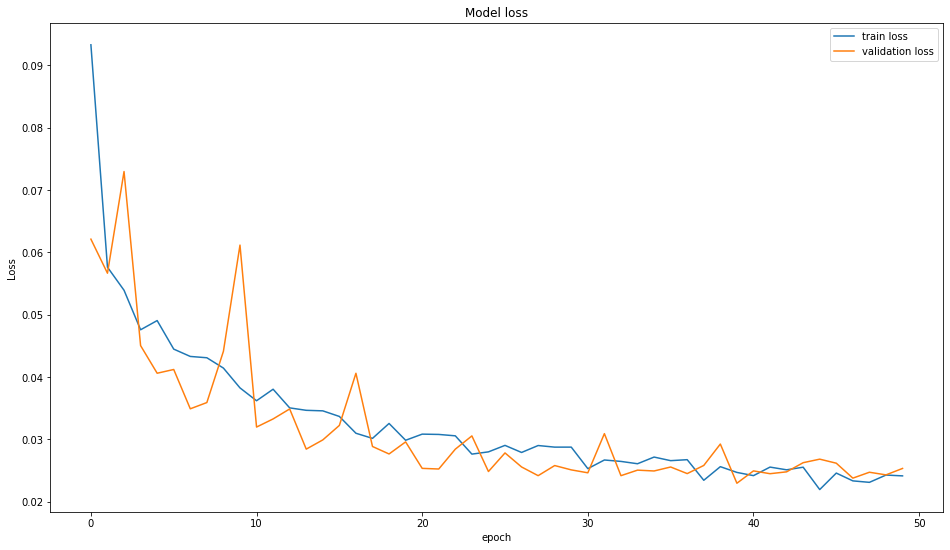

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
preds = trained_model.predict(val_rescaled)

In [ ]:
preds_inverse = scaler.inverse_transform(preds[0])

In [ ]:
ts_eval_metrics(validate, preds_inverse)

Evaluation metrics results: 
MSE: 293702.86099662783
MAE: 382.023876953125
RMSE: 541.9435957704711
MAPE: 60.9329149681968
R^2: 0.8093236818448746



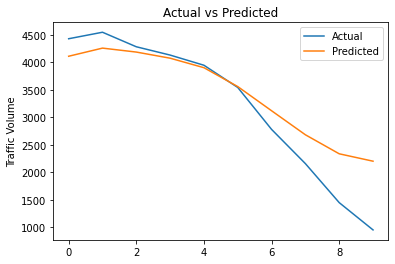

In [ ]:
plt.plot(validate.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# CNN single-step

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Dropout

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.traffic_volume.tail(10)
traffic.drop(traffic.traffic_volume.tail(10).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))
hist_window = 48
horizon = 1
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/cnnlstm_step.h5'

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                 input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense_2 (Dense)             (None, 30)                44190     
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                      

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 27s 10ms/step - loss: 0.0562 - val_loss: 0.0218
Epoch 2/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0271 - val_loss: 0.0161
Epoch 3/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0230 - val_loss: 0.0156
Epoch 4/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0194 - val_loss: 0.0117
Epoch 5/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0196 - val_loss: 0.0125
Epoch 6/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0182 - val_loss: 0.0107
Epoch 7/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.0108
Epoch 8/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0180 - val_loss: 0.0105
Epoch 9/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0179 - val_loss: 0.0109
Epoch 10/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0169 - val_

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

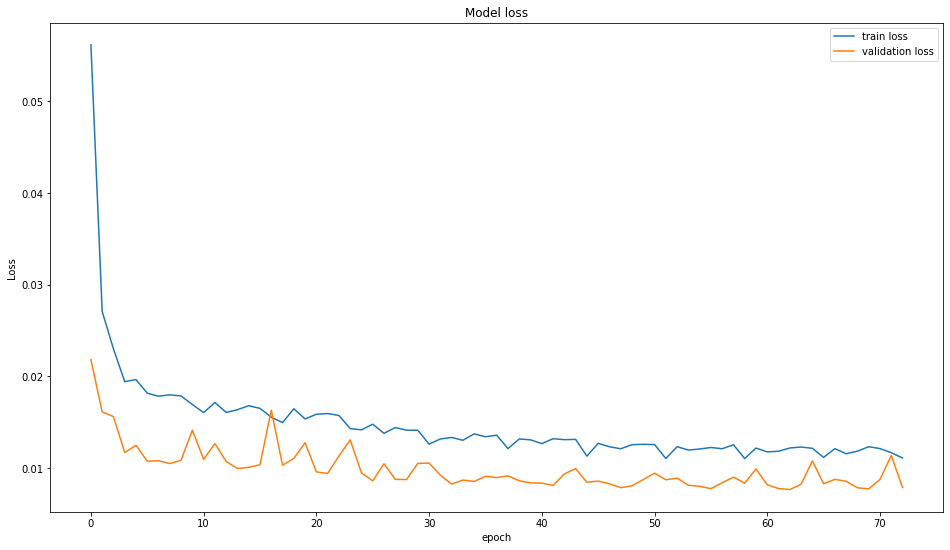

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
window_len = 10
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
for _ in range(1, window_len + 1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    preds = trained_model.predict(val_rescaled)
    result.append(preds[0])
    val_rescaled = np.append(val_rescaled[:, 1:], [[preds]])

In [ ]:
preds_inverse = scaler.inverse_transform(result)

In [ ]:
ts_eval_metrics(validate, preds_inverse)

Evaluation metrics results: 
MSE: 1145404.3851851118
MAE: 826.9706220149994
RMSE: 1070.235668058728
MAPE: 69.89581368459218
R^2: 0.2563862325864785



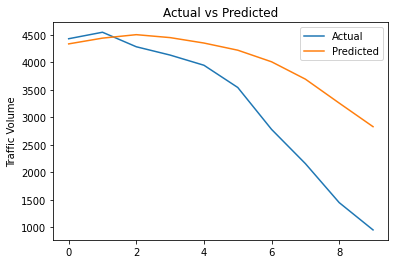

In [ ]:
plt.plot(validate.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# CNN horizon style

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.traffic_volume.tail(10)
traffic.drop(traffic.traffic_volume.tail(10).index, inplace=True)
uni_data = traffic.traffic_volume
uni_data.index = traffic.date_time
uni_data = uni_data.values
scaler = preprocessing.MinMaxScaler()
X_rescaled = scaler.fit_transform(uni_data.reshape(-1, 1))
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_univariate_data_prep(X_rescaled, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_univariate_data_prep(X_rescaled, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/cnnlstm_horizon.h5'

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                 input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 46, 64)            256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 23, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1472)              0         
                                                                 
 dense_4 (Dense)             (None, 30)                44190     
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                      

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 2s 10ms/step - loss: 0.0875 - val_loss: 0.0446
Epoch 2/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0560 - val_loss: 0.0385
Epoch 3/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0506 - val_loss: 0.0568
Epoch 4/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0438 - val_loss: 0.0334
Epoch 5/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0458 - val_loss: 0.0398
Epoch 6/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0426 - val_loss: 0.0344
Epoch 7/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0420 - val_loss: 0.0317
Epoch 8/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0422 - val_loss: 0.0324
Epoch 9/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0415 - val_loss: 0.0342
Epoch 10/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0399 - val

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

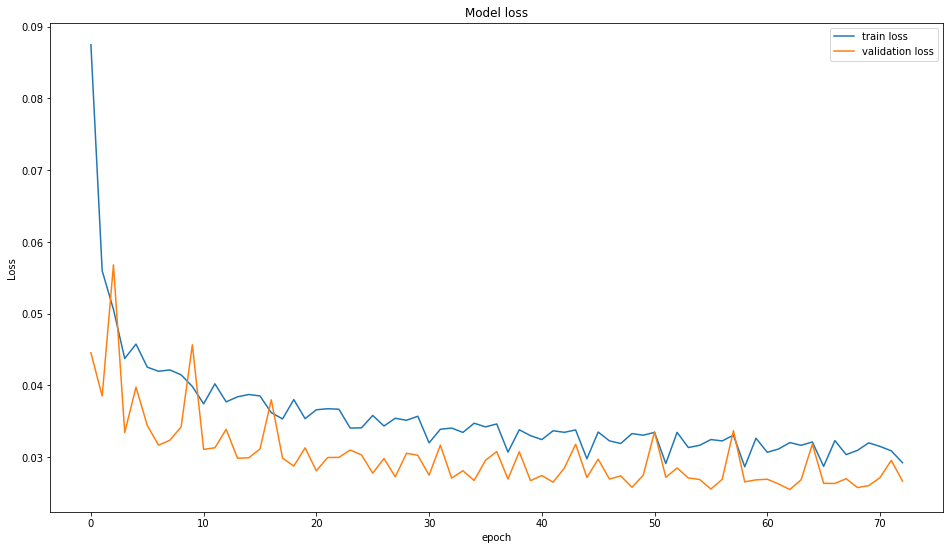

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
uni = traffic.traffic_volume
validatehori = uni.tail(48)
validatehist = validatehori.values
val_rescaled = scaler.transform(validatehist.reshape(-1, 1))
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
preds = trained_model.predict(val_rescaled)

In [ ]:
preds_inverse = scaler.inverse_transform(preds)

In [ ]:
ts_eval_metrics(validate, preds_inverse[0])

Evaluation metrics results: 
MSE: 824905.6567712963
MAE: 683.5353271484375
RMSE: 908.2431705062781
MAPE: 41.297302996241456
R^2: 0.4644588311984732



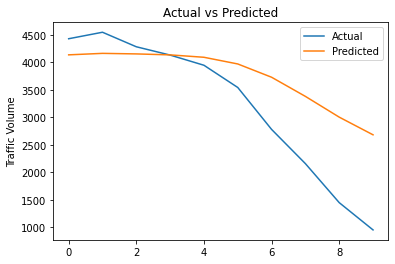

In [ ]:
plt.plot(validate.tolist())
plt.plot(preds_inverse[0])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,35120.000000,35120.000000,35120.000000,35120.000000,35120.000000
mean,281.458469,0.316492,0.000012,39.512927,3321.802249
std,14.229468,52.463389,0.001266,37.796942,1979.798275
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.657500,0.000000,0.000000,1.000000,1314.750000
50%,283.280000,0.000000,0.000000,40.000000,3469.000000
75%,292.772500,0.000000,0.000000,75.000000,4970.000000
max,310.070000,9831.300000,0.210000,100.000000,7280.000000


In [ ]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35120 entries, 0 to 48189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              35120 non-null  object 
 1   temp                 35120 non-null  float64
 2   rain_1h              35120 non-null  float64
 3   snow_1h              35120 non-null  float64
 4   clouds_all           35120 non-null  int64  
 5   weather_main         35120 non-null  object 
 6   weather_description  35120 non-null  object 
 7   date_time            35120 non-null  object 
 8   traffic_volume       35120 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.7+ MB


In [ ]:
for item in traffic.select_dtypes(['object']).columns:
    print(traffic[item].value_counts())

None                         35074
Independence Day                 5
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
State Fair                       5
Memorial Day                     5
Christmas Day                    4
Thanksgiving Day                 4
New Years Day                    4
Labor Day                        3
Martin Luther King Jr Day        1
Name: holiday, dtype: int64
Clouds          15073
Clear           13344
Rain             2602
Mist             1933
Snow             1242
Haze              461
Thunderstorm      235
Drizzle           175
Fog                52
Smoke               2
Squall              1
Name: weather_main, dtype: int64
sky is clear                        11622
overcast clouds                      5059
broken clouds                        4633
scattered clouds                     3442
few clouds                           1939
mist                                 1933
light rain               

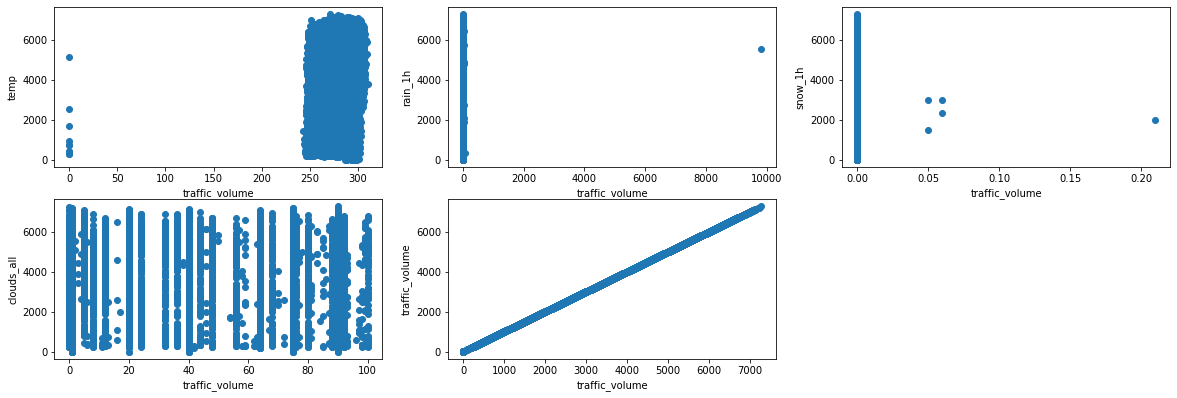

In [ ]:
plt.figure(figsize=(20,10))
for i, col in enumerate(traffic.select_dtypes(['int64', 'float64']).columns):
    plt.subplot(3, 3, i+1)
    plt.scatter(traffic[col], traffic.traffic_volume)
    plt.xlabel('traffic_volume')
    plt.ylabel(f'{col}')
plt.show()

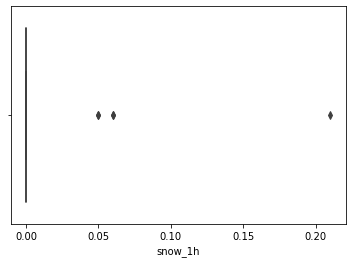

In [ ]:
sns.boxplot(traffic.snow_1h)
plt.show()

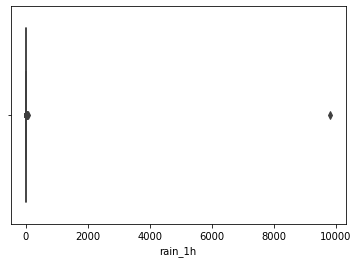

In [ ]:
sns.boxplot(traffic.rain_1h)
plt.show()

In [ ]:
traffic[traffic.rain_1h>8e+3]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,None,302.11,9831.3,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535


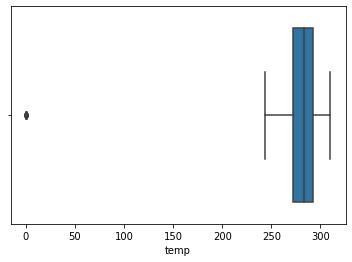

In [ ]:
sns.boxplot(traffic.temp)
plt.show()